In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector 
import seaborn as sns
import matplotlib.pyplot as plt

db = mysql.connector.connect(host = 'localhost',
                             username = 'root',
                             password = '',
                             database = 'ecommerce_customers')

cur = db.cursor()

### 1. Calculate the moving average(take 3 at a time) of order values for each customer over their order history.

In [11]:
query = '''
        select customer_id, order_purchase_timestamp,payment, avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as Avg_payment
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments
join orders
on payments.order_id = orders.order_id) as a
           '''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['Customer Id','Timestamp','Payment','Average Payment'])
df = df.sort_values(by='Customer Id')
df

,Customer Id,Timestamp,Payment,Average Payment
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


### 2. Calculate the cumulative sales per month for each year.

In [12]:
query = '''
       select Years, Months, Payment, sum(Payment) over(order by Years,Months) as Cumulative_Sales 
from 
(select year(orders.order_purchase_timestamp) as Years, month(orders.order_purchase_timestamp) as Months, round(sum(payments.payment_value),2) as Payment
from orders
join payments
on orders.order_id = payments.order_id
group by Years, Months) as a 
           '''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['Year','Month','Payment','Cumulative Sales'])
df = df.sort_values(by='Cumulative Sales')
df

,Year,Month,Payment,Cumulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


### 3. Calculate the year-over-year growth rate of total sales.

In [13]:
query = '''
       with year_wise_payment as (select year(orders.order_purchase_timestamp) as Years, round(sum(payments.payment_value),2) as Payment
from orders
join payments
on orders.order_id = payments.order_id
group by Years
order by Years)

select Years, Payment,((Payment - lag(Payment) over(order by Years))/lag(Payment) over(order by Years))* 100 as yoy_growth_percent
from year_wise_payment;
           '''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['Year','Payment','Year_Year_growth_Percent'])
df = df.sort_values(by='Year')
df

,Year,Payment,Year_Year_growth_Percent
0,2016,59362.34,NaN
1,2017,7249746.73,12112.703761
2,2018,8699763.05,20.000924


### 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [14]:
query = '''
      with a as(select customers.customer_id, min(orders.order_purchase_timestamp) as first_order
from customers
join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) as Retention_Count
from orders
join a
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > a.first_order
and orders.order_purchase_timestamp < date_add(a.first_order, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id)) as Retention_Percent
from a
left join b
on a.customer_id = b.customer_id;
           '''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['Retention Percent'])
# df = df.sort_values(by='Year')
df # it is giving none as none of the customer is purchasing items again withing 6 months.

,Retention Percent
0,None


### 5. Identify the top 3 customers who spent the most money in each year.

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'a9dc96b027d1252bbac0a9b72d837fc6'),
  Text(1, 0, '1d34ed25963d5aae4cf3d7f3a4cda173'),
  Text(2, 0, '4a06381959b6670756de02e07b83815f'),
  Text(3, 0, '1617b1357756262bfa56ab541c47bc16'),
  Text(4, 0, 'c6e2731c5b391845f6800c97401a43a9'),
  Text(5, 0, '3fd6777bbce08a352fddd04e4a7cc8f6'),
  Text(6, 0, 'ec5b2ba62e574342386871631fafd3fc'),
  Text(7, 0, 'f48d464a0baaea338cb25f816991ab1f'),
  Text(8, 0, 'e0a2412720e9ea4f26c1ac985f6a7358')])

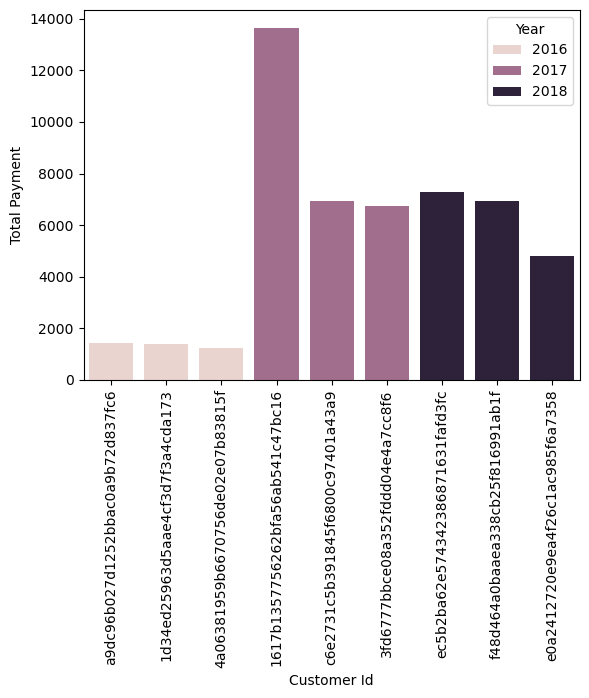

In [18]:
query = '''
select Years, Customer_id, Total_Payment, d_Rank from
(select year(orders.order_purchase_timestamp) Years, orders.customer_id as Customer_id, sum(payments.payment_value) as Total_Payment, 
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) as d_Rank
from orders
join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_Rank <= 3;
           '''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['Year','Customer Id', 'Total Payment', 'D_Rank'])
# df = df.sort_values(by='Year')
sns.barplot(x=df['Customer Id'],y=df['Total Payment'],data=df, hue=df['Year'])
plt.xticks(rotation = 90)